# HT-MEK Data Processing Workbook
Author: Micah Olivas

In [35]:
# This will autoreload imported modules
%load_ext autoreload
%autoreload 2

# Import modules
from experiment_processing import processing

# Set up parallel processing
processing.pandarallel.initialize(progress_bar=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Import kinetic and standard series data

Read raw kinetic and standards data with Pandas

In [155]:
kinetic_data_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/Assays/AcP_titration/d2_TitrationSeries_Analysis.csv.bz2'
standard_data_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/Standards/Analysis/d2_pbp_StandardSeries_Analysis.csv.bz2'
egfp_data_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/eGFP/20230208_173620_d2_quant_PBS_pH7_4_egfp/egfp/StitchedImagesGFP_Summary.csv.bz2'
egfp_button_summary_image_path = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/230207_SFL_nanobody/eGFP/20230208_173620_d2_quant_PBS_pH7_4_egfp/egfp/StitchedImages/SummaryImages_true/Summary_BGSubtracted_StitchedImg_500_egfp_0.tif'

# experiment information
experimental_day = '230207'
experiment_name = 'Acyp_SFL'
setup = 'S7'
device = 'd2'
egfp_slope = 188847
substrate = 'AcP'
all_substrate_concs = [100, 75, 50, 25, 10]
device_columns = 32
device_rows = 56

# export information
export_path_root = "/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation"

# Create dataframes for kinetic and standard series
kinetic_data = processing.pd.read_csv(kinetic_data_path)
standard_data = processing.pd.read_csv(standard_data_path)
egfp_data = processing.pd.read_csv(egfp_data_path)
standard_data = standard_data.dropna()

# Format all dataframes
standard_data, kinetic_data = processing.format_data(standard_data, kinetic_data, substrate, egfp_data)

## Format library member name text

In [19]:
kinetic_data['MutantID'] = kinetic_data['id'].str.replace('human_ACYP2', 'hsapiens2')
standard_data['MutantID'] = standard_data['id'].str.replace('human_ACYP2', 'hsapiens2')

## "Squeeze" DataFrames

At this point, our DataFrames are in a long format: each row of kinetic_data corresponds to an individual timepoint in the kinetic assays, while each row of standard_data corresponds to an individual standard concentration. To support vectorized curve fitting operations later, we want to flatten or "squeeze" rows of each DataFrame into series (e.g. time, intensity, standard concentration) by chamber.

In [36]:
squeeze_kinetics = processing.squeeze_kinetics(kinetic_data)

,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,10,131388,"[0, 75, 150, 225, 301, 377, 456, 533, 609, 687...","[5780, 5814, 5840, 5874, 5885, 5943, 5950, 597..."
1,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,25,131388,"[0, 75, 150, 227, 304, 381, 458, 536, 613, 690...","[8159, 8244, 8335, 8398, 8468, 8546, 8627, 868..."


"Squeeze" standard data to serialize standard concetrations. Plot representative standard curves

,x,y,Indices,substrate,standard_concentration_uM,standard_median_intensities
0,1,1,"01,01",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4475, 5019, 8899, 8235, 12948, 16133, 16120, ..."
1,1,2,"01,02",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4318, 4855, 8611, 7973, 12537, 15646, 15634, ..."
2,1,3,"01,03",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4367, 4898, 8688, 8037, 12666, 15777, 15749, ..."
3,1,4,"01,04",AcP,"[0, 1, 3, 6, 15, 30, 75, 150]","[4214, 4728, 8370, 7761, 12225, 15217, 15182, ..."


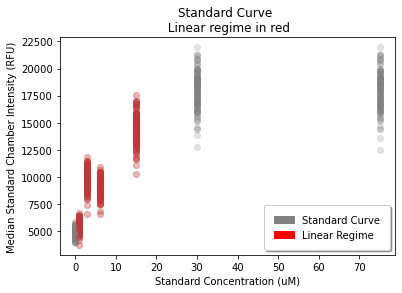

In [37]:
squeeze_standards = processing.squeeze_standard(standard_data)

## Calculate enzyme concentration from eGFP fluorescence

In [38]:
squeeze_kinetics['EnzymeConc'] = squeeze_kinetics['summed_button_BGsub_Button_Quant']/egfp_slope

## Fit PBP Standard Curves

To fit the PBP standard curve, we need to optimize a nonlinear least squares fit based on the following single-site binding isotherm for the phosphate sensor:

$I([Pi]) = 0.5A(KD +[Pi]+[PS]-\sqrt{(KD +[PS]+[Pi])^2 - 4[PS][Pi]}) + I(0μM)$

where $I([Pi])$ is the median fluorescence at a given $[Pi]$, $[PS]$ is the concentration of PBP, $K_D$ is the dissociation constant of Pi from PBP, $A$ is the scaling factor necessary to relate fraction PBP bound to observed fluorescence, and $I(0μM[Pi])$ is the median fluorescence intensity of PBP in the absence of added Pi.

To find product concentrations from measured intensities, we need to invert this isotherm. For this, we use the package `sympy`, which has a nice suite of tools for symbolic math.

In [8]:
A, KD, P_i, PS, I_0uMP_i, I_P_i = symbols('A KD P_i PS I_0uMP_i I_P_i')

isotherm_inverse = solve(0.5 * A * (KD + P_i + PS - ((KD + PS + P_i)**2 - 4*PS*P_i)**(1/2)) + I_0uMP_i - I_P_i, P_i)
print('Inverse of isotherm:', isotherm_inverse)

Inverse of isotherm: [(-A*I_0uMP_i*KD - A*I_0uMP_i*PS + A*I_P_i*KD + A*I_P_i*PS - I_0uMP_i**2 + 2.0*I_0uMP_i*I_P_i - I_P_i**2)/(A*(A*PS + I_0uMP_i - I_P_i))]


If we would like to fit the inverse, we can simply copy this function into the following cell to perform the nonlinear least squares fit. Instead, we will densely interpolate the curve fits for each chamber and use the interpolations to approximate `[Pi]` concentration. The following function optimizes a least squares fit for each standard curve in each chamber and stores the optimum paramters as a list [`A, KD, PS, I_0uMP_i`] in the column `standard_popt`.

Now, let's check a few of the curve fits to make sure they look appropriate

Performing curve fits...


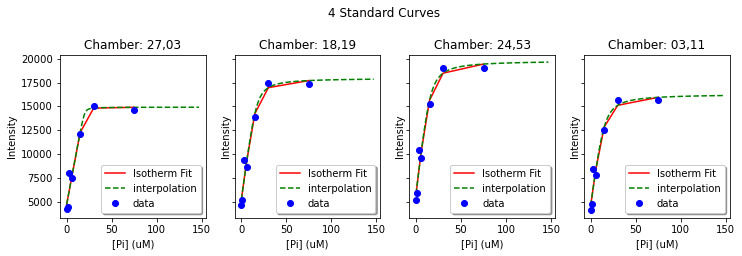

In [41]:
squeeze_standards = processing.standard_curve_fit(squeeze_standards)

## Merge dataframes

Next we merge the standard and kinetic data on the chamber Indices and substrate columns and convert the kinetic median intensities to product concentrations using the standard curve slope. To convert median assay intensities to product concentrations, we interpolate the curve fit and generate a lookup dictionary. This method should be replaced with a rigorous interpolation, but it will do for now.

In [47]:
sq_merged = processing.merge_and_get_product_concs(squeeze_kinetics, squeeze_standards) 
sq_merged.head(1)

Calculating product concentrations...
If interpolating, this may take longer than the curve fitting...


,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,EnzymeConc,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,10,131388,"[0, 75, 150, 225, 301, 377, 456, 533, 609, 687...","[5780, 5814, 5840, 5874, 5885, 5943, 5950, 597...",0.695738,"[0, 1, 3, 6, 15, 30, 75, 150]","[4475, 5019, 8899, 8235, 12948, 16133, 16120, ...","[828.1181524329919, 2.0953878051518657, 14.423...","[1.2, 1.275, 1.275, 1.3499999999999999, 1.3499..."


# Manual eGFP Flagging (only for [E] above the background)

In [144]:
# Point to directory for culling record export
culling_export_directory = '/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce_Progen_Predictions/Small_ACYP_Library/4_Experiments/230207/Interpretation'

# Initialize row and column numbers
NUM_ROWS = 56
NUM_COLS = 32

# Create button grid and display
button_grid, flagged_set, button_stamps = processing.manual_culling(sq_merged, egfp_button_summary_image_path, NUM_ROWS, NUM_COLS, culling_export_directory)
display(button_grid)

No culling record found in export directory. Creating button grid for manual culling...
Button grid object created. Please wait for your viewport to render the grid...


Box(children=(VBox(children=(ToggleButton(value=False, description='(32, 39) 148.2 nM', layout=Layout(height='…

Close button finder, then add culling flag to merged DataFrame and export culling record

In [89]:
# close button grid
if button_grid != None:
    button_grid.close()

# Update sq_merged with flagged chambers and export culling record
sq_merged = processing.handle_flagged_chambers(sq_merged, flagged_set, culling_export_directory)

# Calculate initial rates
To calculate initial rates for each substrate condition, we apply an algorithm adapted from page 27 of the SI in Markin, Mokhtari et al. 2020

Fitting initial rates...
Done fitting initial rates. Adding results to dataframe...
Plotting progress curves for one random mutant...


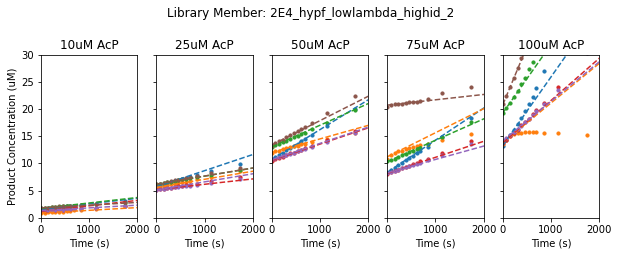

In [99]:
sq_merged = processing.get_initial_rates(sq_merged, pbp_conc=30)

# Michaelis-Menten curve fitting

To perform the fitting, we apply another "squeeze" to create columns for the substrate concentration series and initial rate series. Scale initial rates by enzyme concentration. If there is no measurement for a zero substrate condition, a zero placeholder is added to the beginning of the substrate conc and initial rate lists.

Fitting Michaelis-Menten curves...


/Users/micaholivas/Desktop/htmek_processing/experiment_processing/processing.py:704: RuntimeWarning: divide by zero encountered in double_scalars
  kcat_over_KM_fit = 10**6 * kcat_fit/KM_fit # at this point, kcat in s^-1 and KM in uM, so multiply by 1000000 to give s^-1 * M^-1
/Users/micaholivas/Desktop/htmek_processing/experiment_processing/processing.py:704: RuntimeWarning: divide by zero encountered in double_scalars
  kcat_over_KM_fit = 10**6 * kcat_fit/KM_fit # at this point, kcat in s^-1 and KM in uM, so multiply by 1000000 to give s^-1 * M^-1


Done fitting Michaelis-Menten curves.
Plotting examples...


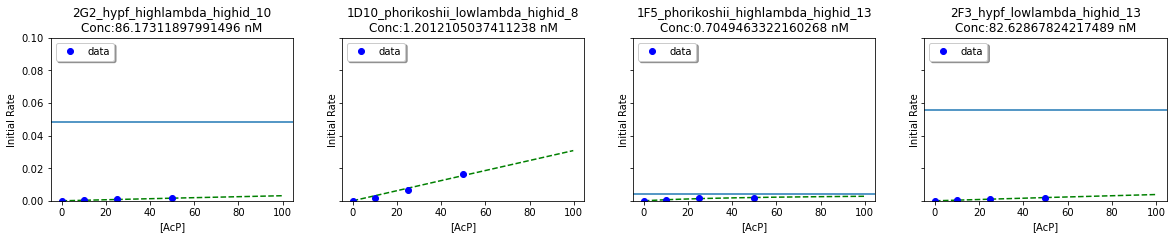

In [137]:
squeeze_mm = processing.fit_michaelis_menten(sq_merged, exclude_concs=[100, 75])

# Calculate local background ratio
Add as a row in the by-chamber, by-substrate concentration dataframe, then squeeze into a list in the MM dataframe 

Next, iterate row-wise across the dataframe and compute the local background ratio. This algorithm is as follows: 
    1. for each chamber, store the intial rate for the highest substrate concentration condition
    2. coerce all rates below 0.00001 to zero
    3. store the rates in the above and below chambers
        2.1. 
        2.2. average rates

In [148]:
squeeze_mm, sq_merged = processing.calculate_local_bg_ratio(squeeze_mm, sq_merged, device_rows=device_rows, exclude_concs=[100, 75])
squeeze_mm.head(5)

/Users/micaholivas/Desktop/htmek_processing/experiment_processing/processing.py:818: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_bg_df['index_tuple'] = local_bg_df.apply(lambda row: (row.x, row.y), axis=1)


,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,local_bg_ratio
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,0.695738,False,"[0, 10, 25, 50]","[0, 0.0004999999999999972, 0.00197357031565584...",58.481337,0.005595,8.041346,137502.781325,0.498994
1,1,2,"01,02",BLANK,AcP,0.748659,False,"[0, 10, 25, 50]","[0, 0.0005000000000000003, 0.00197357031565585...",6124.741780,0.578757,773.058731,126218.991503,0.953020
2,1,3,"01,03",2A4_sbenthica_lowlambda_highid_7,AcP,79.585802,False,"[0, 10, 25, 50]","[0, 0.0009999999999999944, 0.00345158404985865...",6060.770271,0.934195,11.738207,1936.751736,2.134228
3,1,4,"01,04",BLANK,AcP,0.578781,False,"[0, 10, 25, 50]","[0, 0.0004999999999999988, 0.00197357031565585...",58.481341,0.005595,9.666302,165288.651539,0.453797
4,1,5,"01,05",1G1_phorikoshii_lowlambda_lowid_8,AcP,0.380769,False,"[0, 10, 25, 50]","[0, 0.0005000000000000003, 0.00148234173928098...",995.843589,0.061595,161.764727,162439.894120,0.924031


# Print PDFs

Define progress curve plotting function

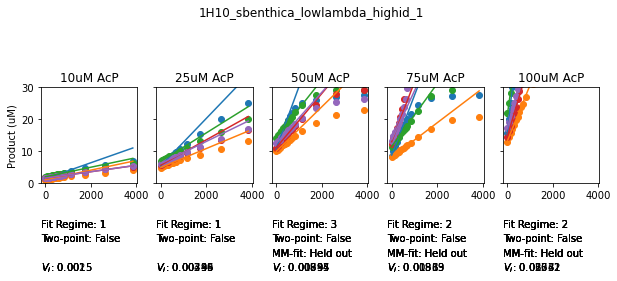

In [241]:
# concs = sorted(list(set(sq_merged['substrate_conc_uM'])))

# # sample a random mutants and subset the progress curve dictionary
# check = np.random.choice(list(set(sq_merged['MutantID'])), 1)[0] # id
# my_df = sq_merged[sq_merged['MutantID'] == check]


# def plot_progress_curve(df, conc, ax, kwargs_for_scatter, kwargs_for_line, fit_descriptors=False, exclude_concs=exclude_concs):
#     """
#     Inputs:
#         - concs: current substrate concentrations
#         - df: current chamber df
#         - ax: position of plot
#         - fit_descriptors: boolean to add descriptors for two-point fit, mm fit exclusion, and initial rate fit regime
#     """

#     # create a df of substrate concentrations
#     conc_df = df[df['substrate_conc_uM'] == conc]


#     for index, row in conc_df.iterrows():

#         times, product_concs = np.array(row['time_s']), row['kinetic_product_concentration_uM']
#         vi = row['initial_rate']
#         intercept = row['initial_rate_intercept']
#         regime = row['rate_fit_regime']
#         two_point_fit = row['two_point_fit']

#         # plot data for the current chamber
#         ax.scatter(times, product_concs, **kwargs_for_scatter) # plot progress curve
#         ax.plot(times, (times*vi) + intercept, **kwargs_for_line) # plot initial rate line
#         # ax.set_xticklabels([]) # remove tick labels

#         if fit_descriptors==True:

#             # add regime text
#             ax.text(0, -0.45, "Fit Regime: " + str(regime), transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots

#             # add two-point fit
#             if two_point_fit == True:
#                 ax.text(0, -0.6, "Two-point: " + str(two_point_fit), color='red', transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots
#             else:
#                 ax.text(0, -0.6, "Two-point: " + str(two_point_fit), transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots
            
#             # add MM exclusion text
#             if conc in exclude_concs:
#                 ax.text(0, -0.75, "MM-fit: Held out", transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots

#             # add initial rate text
#             ax.text(0, -0.9, "$V_i$: " + str(round(vi, 5)), transform=ax.transAxes) # Here, transAxes applies a transform to the axes to ensure that spacing isn't off between plots

#         ax.set_title(str(conc) + 'uM AcP')
#         ax.set_box_aspect(1)
#         # ax.set_ylim([0, max(product_concs)*1.2])
#         ax.set_ylim([0, 30])


# # set figure settings
# fig, axs = plt.subplots(ncols=5, figsize=(10,3), sharey=True)

# # test plotting function
# for conc, ax in dict(zip(concs, axs)).items():
#     plot_progress_curve(my_df, conc, ax, kwargs_for_scatter={}, kwargs_for_line={}, fit_descriptors=True)

# axs[0].set_ylabel('Product (uM)')
# fig.suptitle(check, y=1.1)
# plt.show()

Define heatmap function

In [242]:
# def heatmap(data, ax=None, norm=None,
#             cbar_kw=None, cbarlabel="", display_cbar=True, **kwargs):
#     """
#     Create a heatmap from a numpy array and two lists of labels.

#     Parameters
#     ----------
#     data
#         A 2D numpy array of shape (M, N).
#     row_labels
#         A list or array of length M with the labels for the rows.
#     col_labels
#         A list or array of length N with the labels for the columns.
#     ax
#         A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
#         not provided, use current axes or create a new one.  Optional.
#     cbar_kw
#         A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
#     cbarlabel
#         The label for the colorbar.  Optional.
#     **kwargs
#         All other arguments are forwarded to `imshow`.
#     """

#     # if ax is None:
#     #     ax = plt.gca()

#     if cbar_kw is None:
#         cbar_kw = {}

#     # Plot the heatmap
#     im = ax.imshow(data, aspect='equal', **kwargs)

#     # Create colorbar
#     if display_cbar == True:
#         norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#         cbar = ax.figure.colorbar(im, ax=ax, norm=norm, **cbar_kw)
#         cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
#     else:
#         cbar = None

#     # Let the horizontal axes labeling appear on top.
#     ax.tick_params(top=True, bottom=False,
#                    labeltop=True, labelbottom=False)

#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#              rotation_mode="anchor")

#     ax.tick_params(which="minor", bottom=False, left=False)

#     return im, cbar

Generate summary PDFs

/var/folders/tk/b6dtl2bj2sxbd1x_0nt6z7tr0000gn/T/ipykernel_95708/2473226210.py:37: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = ax.figure.colorbar(im, ax=ax, norm=norm, **cbar_kw)


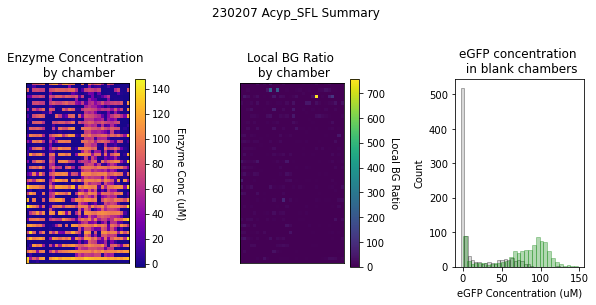

Processing (2, 8):   4%|▎         | 64/1792 [01:23<37:23,  1.30s/it]   


KeyboardInterrupt: 

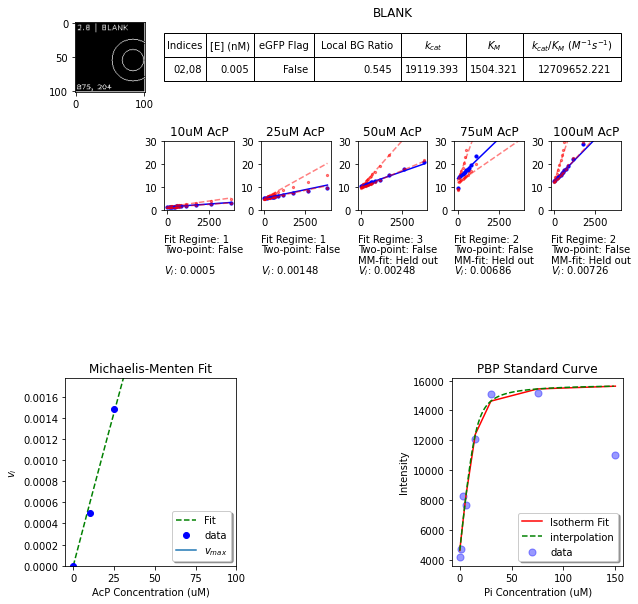

In [243]:
# # Plot Chip Summary

# # create export directory
# newpath = export_path_root + '/PDF/pages/'

# if not os.path.exists(newpath):
#     os.makedirs(newpath)

# ## defining figure ============================================================
# # initialize figure
# fig = plt.figure(figsize=(10, 10)) # size of print area of A4 page is 7 by 9.5

# # increase the spacing between the subplots
# fig.subplots_adjust(wspace=4, hspace=0.7)
# fig.suptitle(' '.join([experimental_day, experiment_name, 'Summary']))

# ## defining subplots ============================================================
# ax_conc_heatmap = plt.subplot2grid((5, 6), (0, 0), rowspan=2, colspan=2) # enzyme concentration heatmap
# ax_kinetic_heatmap = plt.subplot2grid((5, 6), (0, 2), rowspan=2, colspan=2) # enzyme concentration heatmap
# ax_egfp_hist = plt.subplot2grid((5, 6), (0, 4), rowspan=2, colspan=2) # enzyme concentration heatmap


# ## Heatmap plotting ============================================================
# # fill NaN
# grid = squeeze_mm.fillna(0)

# # plot enz conc
# grid_EC = grid.pivot('x', 'y', 'EnzymeConc').T
# grid_EC = grid_EC[grid_EC.columns[::-1]] # flip horizontally
# grid_EC = np.array(grid_EC)
# display_cbar=True # only display cbar on last grid
# norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
# im, cbar = heatmap(grid_EC,
#                     cmap="plasma", 
#                     cbarlabel="Enzyme Conc (uM)", 
#                     display_cbar=display_cbar,
#                     ax=ax_conc_heatmap,
#                     norm=norm
#                     )
# ax_conc_heatmap.set_xticks([])
# ax_conc_heatmap.set_yticks([])
# ax_conc_heatmap.set_title('Enzyme Concentration \n by chamber')

# # plot enz LBG
# grid_kinetic = grid.pivot('x', 'y', 'local_bg_ratio').T
# grid_kinetic = grid_kinetic[grid_kinetic.columns[::-1]] # flip horizontally
# grid_kinetic = np.array(grid_kinetic)
# display_cbar = True # only display cbar on last grid
# norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
# im, cbar = heatmap(grid_kinetic,
#                     cmap="viridis", 
#                     cbarlabel="Local BG Ratio", 
#                     display_cbar=display_cbar,
#                     norm=norm,
#                     ax=ax_kinetic_heatmap,
#                     )
# ax_kinetic_heatmap.set_xticks([])
# ax_kinetic_heatmap.set_yticks([])
# ax_kinetic_heatmap.set_title('Local BG Ratio \n by chamber')


# ## Histogram plotting ============================================================

# # remove blank chambers
# all_blanks = sq_merged[sq_merged['MutantID'] == 'BLANK'][[ "Indices", 'MutantID', 'EnzymeConc']].drop_duplicates(subset=['Indices'], keep='first')
# all_library = sq_merged[sq_merged['MutantID'] != 'BLANK'][[ "Indices", 'MutantID', 'EnzymeConc']].drop_duplicates(subset=['Indices'], keep='first')

# # plot histograms
# n, bins, patches = plt.hist(all_blanks['EnzymeConc'], stacked=True, bins=30, facecolor='grey', alpha=0.3, edgecolor='black')
# n, bins, patches = plt.hist(all_library['EnzymeConc'], stacked=True, bins=30, facecolor='green', alpha=0.3, edgecolor='green')

# # set plot 
# ax_egfp_hist.set_xlabel('eGFP Concentration (uM)')
# ax_egfp_hist.set_ylabel('Count')
# ax_egfp_hist.set_title('eGFP concentration \n in blank chambers')

# plt.savefig(newpath + '00_Chip_Summary.pdf')
# plt.show()



# # initialize tqdm
# with tqdm(total = device_columns * device_rows) as pbar:

#     # Plot Chamber-wise Summaries
#     for x in range(1, 33):
#         for y in range(1, 57, 1):
            
#             ## initialize data df ============================================================
#             export_kinetic_df = sq_merged[sq_merged['Indices'] == f"{x:02d}" + ',' + f"{y:02d}"]
#             export_standards_df = squeeze_standards[squeeze_standards['Indices'] == f"{x:02d}" + ',' + f"{y:02d}"]
#             export_mm_df = squeeze_mm[squeeze_mm['Indices'] == f"{x:02d}" + ',' + f"{y:02d}"]
            
#             ## defining figure ============================================================
#             # initialize figure
#             fig = plt.figure(figsize=(10, 10)) # size of print area of A4 page is 7 by 9.5

#             # increase the spacing between the subplots
#             fig.subplots_adjust(wspace=0.3, hspace=0.7)

#             ## defining subplots ============================================================
#             ax_image = plt.subplot2grid((5, 5), (0, 0), colspan=1) # chamber image
#             ax_first_progress_curve = plt.subplot2grid((5, 6), (1, 1), colspan=1) # progress curves
#             ax_second_progress_curve = plt.subplot2grid((5, 6), (1, 2), colspan=1, sharey=ax_first_progress_curve) # progress curves
#             ax_third_progress_curve = plt.subplot2grid((5, 6), (1, 3), colspan=1, sharey=ax_first_progress_curve) # progress curves
#             ax_fourth_progress_curve = plt.subplot2grid((5, 6), (1, 4), colspan=1, sharey=ax_first_progress_curve) # progress curves
#             ax_fifth_progress_curve = plt.subplot2grid((5, 6), (1, 5), colspan=1, sharey=ax_first_progress_curve) # progress curves
#             ax_table = plt.subplot2grid((5, 6), (0, 1), colspan=5) # table
#             ax_mm_curve = plt.subplot2grid((5, 6), (3, 0), rowspan=2, colspan=2) # chamber image
#             ax_pbp_std_curve = plt.subplot2grid((5, 6), (3, 4), rowspan=2, colspan=2) # chamber image


#             ## image plotting ============================================================
#             img_idx = (x, y)
#             ax_image.imshow(button_stamps[img_idx], cmap='gray', vmin=0, vmax=np.max(button_stamps[img_idx]))


#             ## PBP std curve fit  ============================================================
#             xdata, ydata = export_standards_df.standard_concentration_uM.values[0], export_standards_df.standard_median_intensities.values[0]
#             chamber_popt = export_standards_df.standard_popt.values[0]

#             # define the interpolation
#             interp_xdata = np.linspace(-np.min(xdata), np.max(xdata), num=100, endpoint=False)

#             # plot
#             ax_pbp_std_curve.plot(xdata, v_isotherm(xdata, *chamber_popt), 'r-', label='Isotherm Fit')
#             ax_pbp_std_curve.plot(interp_xdata, v_isotherm(interp_xdata, *chamber_popt), color='g', linestyle='dashed', label='interpolation')
#             ax_pbp_std_curve.scatter(xdata, ydata, color='b', s=50, alpha=0.4, label='data')
#             ax_pbp_std_curve.set_ylabel('Intensity')
#             ax_pbp_std_curve.set_xlabel('Pi Concentration (uM)')
#             ax_pbp_std_curve.legend(loc='lower right', shadow=True)
#             ax_pbp_std_curve.set_title('PBP Standard Curve')


#             ## Michaelis-Menten curve plotting ============================================================
#             xdata = export_mm_df.iloc[0].substrate_concs
#             ydata = export_mm_df.iloc[0].initial_rates
#             MutantID = export_mm_df.iloc[0].MutantID
#             Indices = export_mm_df.iloc[0].Indices
#             KM_fit = export_mm_df.iloc[0].KM_fit
#             vmax_fit = export_mm_df.iloc[0].vmax_fit

#             # plot
#             t = np.arange(0, 100, 0.2)
#             fit_ydata = vfunc(t, *[KM_fit, vmax_fit])
#             ax_mm_curve.plot(t, fit_ydata, 'g--', label='Fit') 
#             ax_mm_curve.plot(xdata, ydata, 'bo', label='data')
#             ax_mm_curve.axhline(vmax_fit, label='$v_{max}$')
#             # ax_mm_curve.axvline(KM_fit, ymin=0, ymax=(vmax_fit/.2))
#             ax_mm_curve.set_ylabel('$v_i$')
#             ax_mm_curve.set_xlabel('AcP Concentration (uM)')
#             ax_mm_curve.set_ylim([0, max(ydata)*1.2])
#             ax_mm_curve.set_xlim([-max(set(squeeze_kinetics.substrate_conc_uM))/20, max(set(squeeze_kinetics.substrate_conc_uM))])
#             ax_mm_curve.legend(loc='lower right', fancybox=True, shadow=True)
#             ax_mm_curve.set_title('Michaelis-Menten Fit')


#             ## progress curve plotting ============================================================
#             concs = set(export_kinetic_df['substrate_conc_uM'])
            
#             # find local background indices and store data in new df
#             local_background_indices = get_local_bg_indices(x=x, y=y) # stores indices of local background chambers in a list
#             local_background_df = pd.DataFrame([])
#             for i in local_background_indices:
#                 data = sq_merged[sq_merged['Indices'] == f"{i[0]:02d}" + ',' + f"{i[1]:02d}"]
#                 local_background_df = local_background_df.append(data)

#             # plot curves
#             plot_progress_curve(export_kinetic_df, 10, ax_first_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
#             plot_progress_curve(local_background_df, 10, ax_first_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})

#             plot_progress_curve(export_kinetic_df, 25, ax_second_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
#             plot_progress_curve(local_background_df, 25, ax_second_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})

#             plot_progress_curve(export_kinetic_df, 50, ax_third_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
#             plot_progress_curve(local_background_df, 50, ax_third_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})

#             plot_progress_curve(export_kinetic_df, 75, ax_fourth_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
#             plot_progress_curve(local_background_df, 75, ax_fourth_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})
            
#             plot_progress_curve(export_kinetic_df, 100, ax_fifth_progress_curve, fit_descriptors=True, kwargs_for_scatter={"s": 10, "c": 'blue'}, kwargs_for_line={"c": 'blue'})
#             plot_progress_curve(local_background_df, 100, ax_fifth_progress_curve, kwargs_for_scatter={"s": 5, "c": 'red', 'alpha': 0.5}, kwargs_for_line={"c": 'red', 'alpha': 0.5, 'linestyle': 'dashed'})


#             ## table plotting ============================================================
#             table_df = export_mm_df[['Indices', 'EnzymeConc', 'egfp_manual_flag', 'local_bg_ratio', 'kcat_fit', 'KM_fit', 'kcat_over_KM_fit']]
#             table_df.apply(pd.to_numeric, errors='ignore', downcast='float')
#             table_df = table_df.round(decimals=3)

#             table = ax_table.table(cellText=table_df.values, loc='center', colLabels=['Indices', '[E] (nM)', 'eGFP Flag', 'Local BG Ratio', '$k_{cat}$', '$K_M$', '$k_{cat}/K_M$ ($M^{-1} s^{-1}$)'])
#             table.auto_set_font_size(True)
#             table.scale(0.3, 2)
#             table.auto_set_column_width(col=list(range(len(table_df.columns))))
#             ax_table.set_title(export_kinetic_df.iloc[0].MutantID)
#             ax_table.set_axis_off()
#             ax_table.set_frame_on(False)

#             # update progress bar
#             pbar.update(1)
#             pbar.set_description("Processing %s" % str((x, y)))

#             plt.savefig(newpath + str(Indices) + '.pdf')
#             plt.close('all')

#     pbar.set_description("Export complete")

In [152]:
squeeze_kinetics.substrate_conc_uM

0        10
1        25
2        50
3        75
4       100
       ... 
8955     10
8956     25
8957     50
8958     75
8959    100
Name: substrate_conc_uM, Length: 8960, dtype: int64

/Users/micaholivas/Desktop/htmek_processing/experiment_processing/processing.py:956: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = ax.figure.colorbar(im, ax=ax, norm=norm, **cbar_kw)


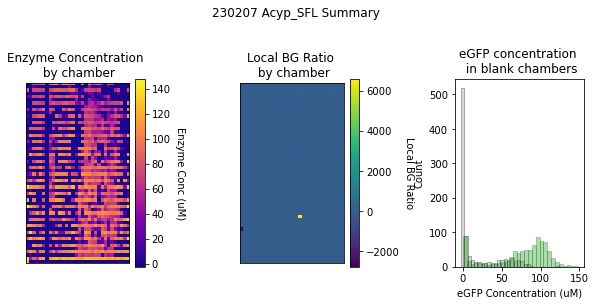

Processing (2, 31):   5%|▍         | 87/1792 [00:59<20:10,  1.41it/s]

In [159]:
processing.plot_chip_summary(squeeze_mm=squeeze_mm, sq_merged=sq_merged, squeeze_standards=squeeze_standards, squeeze_kinetics=squeeze_kinetics, button_stamps=button_stamps, device_columns=device_columns, device_rows=device_rows, export_path_root=export_path_root, experimental_day=experimental_day, experiment_name=experiment_name, exclude_concs=[])

#### Merge PDFs

In [ ]:
from os import listdir
from os.path import isfile, join
import PyPDF2

mypath = export_path_root + '/PDF/'

# store all pdf files
all_files = sorted([mypath + 'pages/' + f for f in listdir(mypath + 'pages/') if isfile(join(mypath + 'pages/', f))])
all_files = [f for f in all_files if f[-4:] == '.pdf']

# initialize merger
merger = PyPDF2.PdfFileMerger()

# merge pdfs
for pdf in all_files:
    merger.append(pdf)

# write merged file
merger.write(mypath + "merged.pdf")
merger.close()


# Export Data

In [244]:
# define export df
export_df = pd.merge(squeeze_mm, sq_merged, on=list(np.intersect1d(sq_merged.columns, squeeze_mm.columns)))

# add remaining data
export_df['GlobalExperimentIndex'] = '_'.join([experimental_day, setup, device, substrate])
export_df['Experiment'] = experiment_name

In [245]:
export_df.to_csv(export_path_root + '/' + experimental_day + '_' + substrate + '_workup.csv')

# Added: SFL Analysis

Enzyme Concentration

In [ ]:
# fill NaN
grid = squeeze_mm.fillna(0)

# plot enz conc
grid_EC = grid.pivot('x', 'y', 'EnzymeConc').T
grid_EC = grid_EC[grid_EC.columns[::-1]] # flip horizontally
grid_EC = np.array(grid_EC)
display_cbar = True
im, cbar = heatmap(grid_EC,
                    cmap="plasma", 
                    cbarlabel="Enzyme Conc (uM)", 
                    display_cbar=display_cbar,
                    )
plt.xlabel("Column")
plt.ylabel("Row")

plt.savefig('/Users/micaholivas/Desktop/Stanford/Research/Presentations/Salesforce/4_Outcomes_203_1/SFL_update_013023/enz_conc_heatmap_SFL_1022.png')
# plt.title('Enzyme Concentration \n by chamber')


Additional [E] from additional experiment

/Users/micaholivas/Desktop/Stanford/Research/Projects/Salesforce Progen Predictions/Small ACYP Library/4_Experiments/221201/Craig workup/221201_S2d2Acyp_SFL.csv.bz2